In [1]:
import os
import re
import unicodedata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Palatino Linotype'
mpl.rcParams['font.serif'] = ['Palatino Linotype']
print("Done")


Done


In [2]:
df = pd.read_csv('final_df.csv')
df.head(5)
print("Done")

Done


In [3]:
# TASK 1: let's extract city names from text columns
df['city'] = df['text'].str.extract(r'#(\w+)', expand = False)

# delete SOS and NaN values. As we do this, we also get rid of values like "Some fields are missing."
df = df[df['city'] != 'SOS']
df.dropna(subset = ['city'], inplace = True)

# set all cities to lowercase to avoid duplicates
df['city'] = df['city'].str.lower()

# delete values that are numbers
df = df[df['city'].str[0] != '9']
df.head(5)

,likes,replies,retweets,text,timestamp,url,date,city
0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...,2023-09-18,mohali
2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,lucknow
3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi
4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,jabalpur
5,12,0,78,#Delhi Need Blood B+ve 2 units at Manipal Hosp...,2023-09-17 08:40:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi


In [4]:
# import real cities in India
real_cities = pd.read_excel('worldcities.xlsx')
real_cities = real_cities[real_cities['country'] == 'India'].loc[:, 'city'].str.lower()

# let's normalize real city names so all letters are from english alphabet
def normalize_city_name(city_name):
    normalized_name = ''.join([c for c in unicodedata.normalize('NFD', city_name) if not unicodedata.combining(c)])
    normalized_name = ' '.join(normalized_name.split())
    normalized_name = normalized_name.lower()
    return normalized_name

real_cities = real_cities.apply(normalize_city_name)

In [5]:
# let's create two lists, one of which contains cities that are real cities in India, while the other contains 
# either non-real cities (villages, etc.) or misspelled cities. I'll handle the second case in the following
# using the Levenshtein distance function.
est = []
netu = []
cities = df['city'].unique()
for i in range(len(cities)):
    if cities[i] in real_cities.values:
        est.append(cities[i])
    else:
        netu.append(cities[i])

In [6]:
def levenshtein_distance(s1, s2):
    matrix = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

    for i in range(len(s1) + 1):
        matrix[i][0] = i
    for j in range(len(s2) + 1):
        matrix[0][j] = j

    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            matrix[i][j] = min(
                matrix[i - 1][j] + 1,
                matrix[i][j - 1] + 1,
                matrix[i - 1][j - 1] + cost)

    return matrix[-1][-1]

dict = {}
for city in netu:
    for real in est:
        if levenshtein_distance(city, real) <= 1:
            dict[city] = real
            continue

In [7]:
# add the following key and value to dict to replace
dict['new'] = 'new delhi'

df['city'] = df['city'].replace(dict)
df.reset_index(inplace = True)
df

,index,likes,replies,retweets,text,timestamp,url,date,city
0,0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...,2023-09-18,mohali
1,2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,lucknow
2,3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi
3,4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,jabalpur
4,5,12,0,78,#Delhi Need Blood B+ve 2 units at Manipal Hosp...,2023-09-17 08:40:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi
...,...,...,...,...,...,...,...,...,...
118053,240656,191,1,83,"Dear #Lucknow, Please help!!",2020-11-09 15:03:17+00:00,https://twitter.com/BloodDonorsIn/status/13258...,2020-11-09,lucknow
118054,240657,183,3,135,#Delhi Need #Blood any group 12 units at ILBS ...,2018-07-29 07:16:35+00:00,https://twitter.com/BloodDonorsIn/status/10234...,2018-07-29,delhi
118055,240658,198,2,38,This request is fulfilled. Thanks to all the d...,2019-07-16 11:49:35+00:00,https://twitter.com/BloodDonorsIn/status/11510...,2019-07-16,bloodmatters
118056,240659,15,2,68,#Kolkata\nNeed #Blood Type : A-negative\nAt :...,2019-07-10 04:57:14+00:00,https://twitter.com/BloodDonorsIn/status/11488...,2019-07-10,kolkata


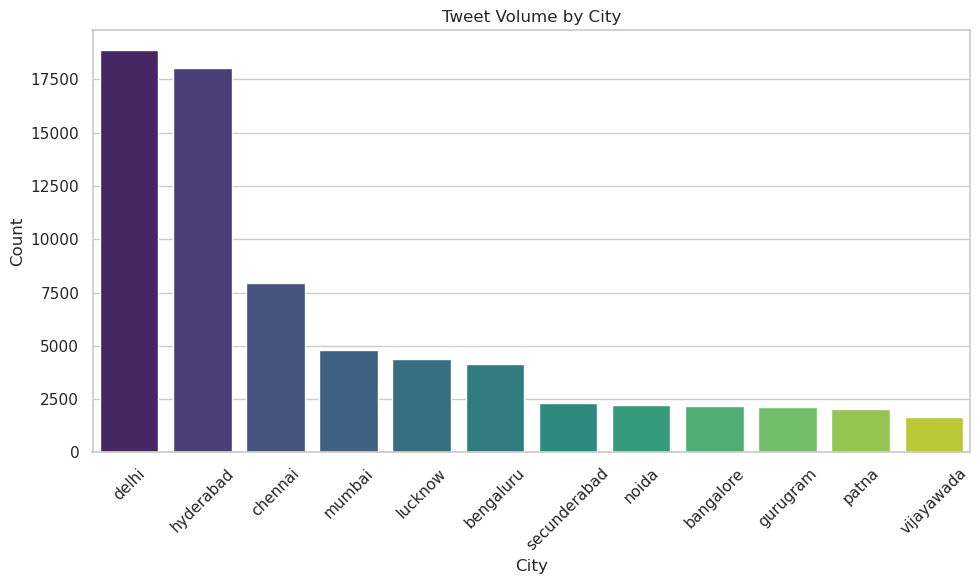

In [8]:

# TASK 4: visualizing tweet volume by cities, specifically, visualizing top-12 cities
city_counts = df['city'].value_counts()
top_cities = city_counts.head(12)

sns.set(style = "whitegrid")
plt.figure(figsize = (10, 6))

sns.barplot(x = top_cities.index, y = top_cities.values, palette = "viridis")
plt.title('Tweet Volume by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.savefig('cities.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [9]:
# TASK 2: let's now extract blood groups from text columns using regex

def replace_blood_types(text):
    # Pattern to match the blood types with positive and negative
    pattern = r'(A|B|AB|O)?(-positive|-negative)'
    
    # Replacement function to convert '-positive' to '+' and '-negative' to '-'
    def replace(match):
        blood_type = match.group(1) if match.group(1) else ''
        sign = '+' if 'positive' in match.group(2) else '-'
        return blood_type + sign
    
    # Replace the occurrences using the pattern and replacement function
    return re.sub(pattern, replace, text)



df['text_b']= df['text'].apply(replace_blood_types)
# Dictionary mapping strings to numbers
number_mapping = {
    'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
    'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
    'eleven': 11, 'twelve': 12
}

# Function to replace case-insensitive strings with numbers
def replace_case_insensitive(string):
    return number_mapping.get(string.lower(), string)

# Apply the function to the DataFrame column
df['text_b'] = df['text_b'].apply(replace_case_insensitive)


df.replace('_', '-', regex=True, inplace=True)
df.replace('=', '-', regex=True, inplace=True)

df.replace('\n', ' ', regex=True, inplace=True)

def find_blood_group(text):
    # Regex pattern for matching blood types with different hyphens and minus signs
    blood_group_pattern = r'(AB|Ab|A|B|OH|Oh|O)[+\-]'
    
    # Search the text for the pattern
    match = re.search(blood_group_pattern, text)
    
    # If a match is found, return the blood group, otherwise return None
    return match.group() if match else None

df['blood_group']= df['text_b'].apply(find_blood_group)
# Handle the case when "Any group" is mentioned and actual blood group is not given
df.loc[df['text_b'].str.contains('Any group', case = False), 'blood_group'] = 'Any'

df['blood_group'].replace('Oh', 'OH', regex=True, inplace=True)









def find_units(text):
    # Regex pattern for matching the number of units
    units_pattern = r'(\d+)\s*unit[s]?'
    
    # Search the text for the pattern
    match = re.search(units_pattern, text, re.IGNORECASE)
    
    # If a match is found, return the number of units as an integer, otherwise return None
    return int(match.group(1)) if match else 1

df['units_a']= df['text_b'].apply(find_units)

def find_number_of_units(text):
    # Regex pattern for matching "Number of Units : X"
    units_pattern = r'Number of Units\s*:\s*(\d+)'
    
    # Search the text for the pattern
    match = re.search(units_pattern, text, re.IGNORECASE)
    
    # If a match is found, return the number of units as an integer, otherwise return None
    return int(match.group(1)) if match else None

df['units_b']= df['text_b'].apply(find_number_of_units)
df.loc[df['units_b'] >= 200, 'units_b'] = np.nan


df['units'] = df['units_b'].combine_first(df['units_a'])
df.loc[df['units'] >= 200, 'units'] = np.nan

df.drop('units_a', axis=1, inplace=True)
df.drop('units_b', axis=1, inplace=True)


def find_blood_product(text):
    # Regex pattern for matching blood, platelets, or plasma
    blood_product_pattern = r'\b(Whole|platelets|SDP|plasma|blood plasma|RDP|PRBC)\b'
    
    # Search the text for the pattern
    match = re.search(blood_product_pattern, text, re.IGNORECASE)
    
    # If a match is found, return the blood product, otherwise return None
    return match.group() if match else "Blood"

df['product']= df['text_b'].apply(find_blood_product)
df['product'].replace('(?i)Whole', 'Blood', regex=True, inplace=True)
df['product'].replace('(?i)blood plasma', 'Plasma', regex=True, inplace=True)
df['product'].replace('(?i)platelets', 'Platelets', regex=True, inplace=True)
df['product'].replace('(?i)sdp', 'Platelets', regex=True, inplace=True)
df['product'].replace('(?i)rdp', 'Platelets', regex=True, inplace=True)
df['product'].replace('(?i)Plasma', 'Plasma', regex=True, inplace=True)
df['product'].replace('(?i)prbc', 'PRBC', regex=True, inplace=True)

    

df.head(200)

,index,likes,replies,retweets,text,timestamp,url,date,city,text_b,blood_group,units,product
0,0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...,2023-09-18,mohali,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,B+,1.0,Platelets
1,2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,lucknow,#Lucknow #UttarPradesh Need Blood Any group 10...,Any,10.0,Blood
2,3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi,#Delhi Need Blood Any group 2 units at BLK Hos...,Any,2.0,Blood
3,4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,jabalpur,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,AB-,2.0,Blood
4,5,12,0,78,#Delhi Need Blood B+ve 2 units at Manipal Hosp...,2023-09-17 08:40:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi,#Delhi Need Blood B+ve 2 units at Manipal Hosp...,B+,2.0,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,367,18,0,101,#Bengaluru #Karnataka Need Blood Platelets Any...,2023-09-08 05:09:00+00:00,https://twitter.com/BloodDonorsIn/status/17000...,2023-09-08,bengaluru,#Bengaluru #Karnataka Need Blood Platelets Any...,Any,1.0,Platelets
196,368,15,2,82,#Thiruvananthapuram #SOS Need Blood OH-ve 2 Un...,2023-09-07 18:28:00+00:00,https://twitter.com/BloodDonorsIn/status/16998...,2023-09-07,thiruvananthapuram,#Thiruvananthapuram #SOS Need Blood OH-ve 2 Un...,OH-,2.0,Blood
197,370,4,0,40,#Raipur #SOS Need Blood Platelets B+ve 2 Units...,2023-09-07 18:22:00+00:00,https://twitter.com/BloodDonorsIn/status/16998...,2023-09-07,raipur,#Raipur #SOS Need Blood Platelets B+ve 2 Units...,B+,2.0,Platelets
198,371,16,0,95,#Bangalore #SOS Need Blood A+ve/Any Group 3 Un...,2023-09-07 18:20:00+00:00,https://twitter.com/BloodDonorsIn/status/16998...,2023-09-07,bangalore,#Bangalore #SOS Need Blood A+ve/Any Group 3 Un...,Any,3.0,Blood


<Figure size 1000x600 with 0 Axes>

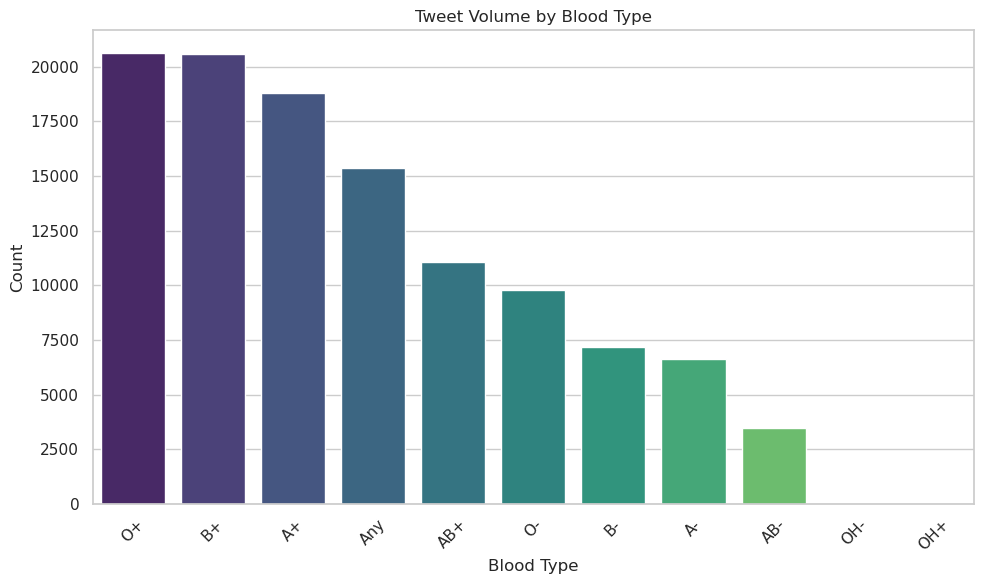

In [11]:
# Let's make the same visualization but studying most popularly-asked blood types 
dict = {'a': 'A', 'Ab-': 'AB-', 'b+': 'B+', 'o': 'O', 'o+': 'O+', 'o-': 'O-', 'b-': 'B-', 'b': 'B',
       'Ab+': 'AB+', 'Ab': 'AB', 'ab': 'AB', 'ab+': 'AB+', 'a+': 'A+'}
df['blood_group'] = df['blood_group'].replace(dict)
df['blood_group'].value_counts()

blood_groups = df['blood_group'].value_counts()

plt.figure(figsize = (10, 6))
plt.figure(figsize = (10, 6))

sns.barplot(x = blood_groups.index, y = blood_groups.values, palette = "viridis")
plt.title('Tweet Volume by Blood Type')
plt.xlabel('Blood Type')
plt.ylabel('Count')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.savefig('bloodgroups.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

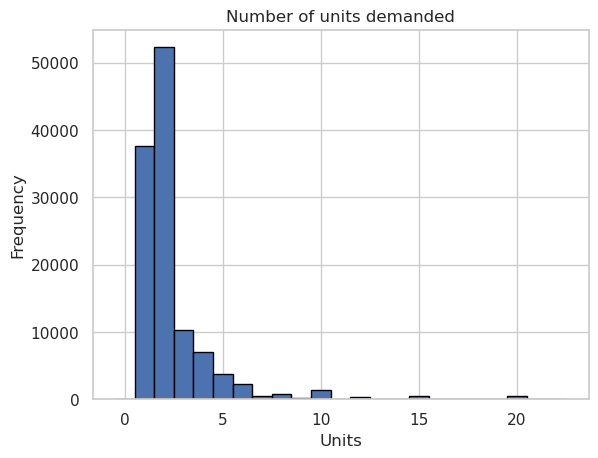

In [12]:
df['product'].value_counts()
df['units'].value_counts()

def remove_outliers(series, factor=20):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (factor * iqr)
    upper_bound = q3 + (factor * iqr)
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Remove outliers from the 'units' column
df['units_no_outliers'] = remove_outliers(df['units'])
max_value = df['units_no_outliers'].max()
bins = np.arange(-0.5, max_value + 1.5, 1)

# Plot the histogram without outliers
plt.hist(df['units_no_outliers'].dropna(),bins=bins,edgecolor='black')
plt.title('Number of units demanded')
plt.xlabel('Units')
plt.ylabel('Frequency')
plt.savefig('units.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

df.drop('units_no_outliers', axis=1, inplace=True)
df.drop('text_b', axis=1, inplace=True)


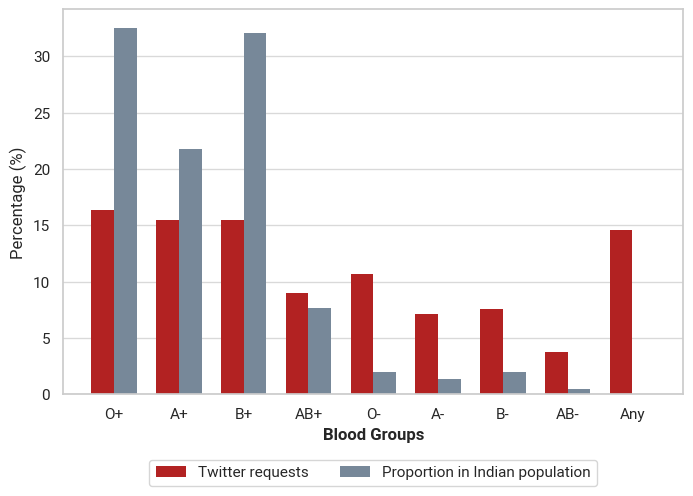

In [14]:
blood_df = df[df['product'] == 'Blood']

blood_group_counts = blood_df['blood_group'].value_counts(normalize=True) * 100

# Proportions of blood groups in the Indian population
# The order of blood groups should match your dataset (from here: https://en.wikipedia.org/wiki/Blood_type_distribution_by_country)
indian_population_proportions = [32.53, 21.80, 32.10, 7.70, 2.03, 1.36, 2.00, 0.48,0]

# Ensure the blood group categories are in the same order as the Indian population data
blood_group_categories = ['O+', 'A+', 'B+', 'AB+', 'O-', 'A-', 'B-', 'AB-', 'Any']
blood_group_counts = blood_group_counts.reindex(blood_group_categories).fillna(0)

from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

import matplotlib.font_manager



# Register the font with Matplotlib
plt.rcParams['font.family'] = 'Roboto' # Roboto' # 'Libertine'
# plt.rcParams['font.pala'] = FontProperties(fname=palatino_path)


# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))

# Set position of bar on X axis
bar_width = 0.35
r1 = np.arange(len(blood_group_counts))
r2 = [x + bar_width for x in r1]

# Make the plot
ax.bar(r1, blood_group_counts, color='firebrick', width=bar_width, edgecolor='none', label='Twitter requests')
ax.bar(r2, indian_population_proportions, color='lightslategray', width=bar_width, edgecolor='none', label='Proportion in Indian population')

# Add xticks on the middle of the group bars
ax.set_xlabel('Blood Groups', fontweight='bold')
ax.set_xticks([r + bar_width / 2 for r in range(len(blood_group_counts))])
ax.set_xticklabels(blood_group_categories)

ax.yaxis.grid(True, linestyle='-', which='major', color='black', alpha=0.15)
ax.xaxis.grid(True, linestyle='-', which='major', color='black', alpha=0.0)


# Create legend & Show graphic
ax.legend()
plt.ylabel('Percentage (%)')
# plt.title('Twitter requests vs. population proportions', fontsize=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),  fancybox=True, ncol=2)

plt.savefig('twitter_vs_pop.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [15]:
# ABO and Rh blood type distribution in India
blood_groups = df['blood_group'].unique()
bg_dict = {'population': df.shape[0]}

for blood_group in blood_groups:
    blood_group_prop = df[df['blood_group'] == blood_group].shape[0] / bg_dict['population']
    bg_dict[blood_group] = [blood_group_prop]

a = pd.DataFrame(bg_dict)
a

,population,B+,Any,AB-,AB+,O+,B-,A+,A-,O-,OH-,None,OH+
0,118058,0.174491,0.130131,0.029494,0.093717,0.174804,0.060826,0.159413,0.056057,0.082798,0.000042,0.0,0.000034


/tmp/ipykernel_241426/3560683052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blood_df['date'] = pd.to_datetime(blood_df['date'])


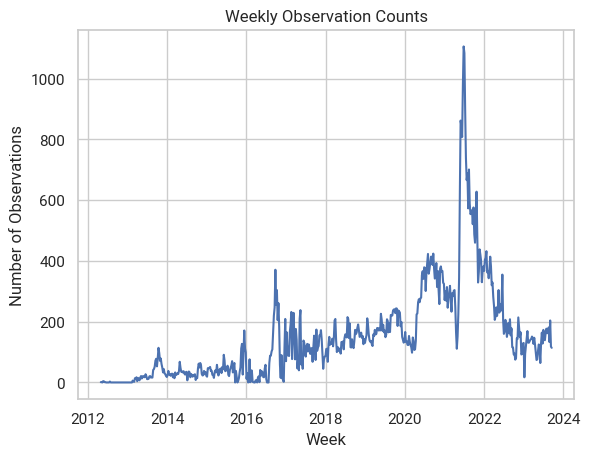

In [24]:

# Group by week and sum the values for each week
blood_df['date'] = pd.to_datetime(blood_df['date'])

# Group by week and count the number of observations for each week
weekly_counts = blood_df.groupby(pd.Grouper(key='date', freq='W-SUN')).size()

# Plot the data
plt.plot(weekly_counts.index, weekly_counts.values)

# Labeling and formatting
plt.xlabel('Week')
plt.ylabel('Number of Observations')
plt.title('Weekly Observation Counts')

# Show the plot
plt.show()

weekly_counts.to_excel('weekly_counts.xlsx', header=['Observation Count'])


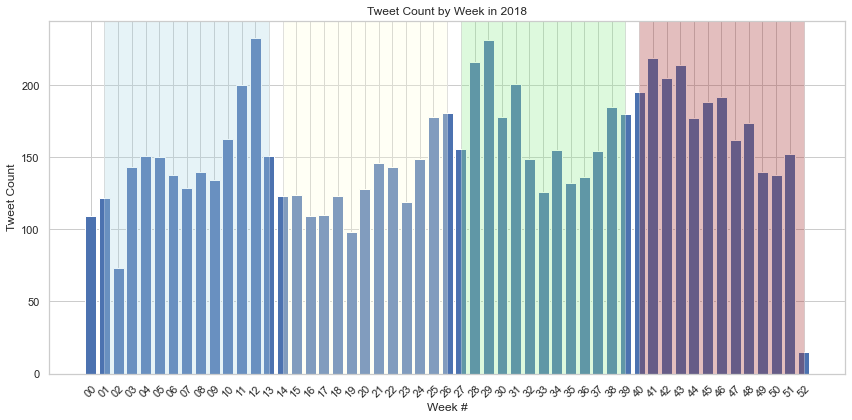

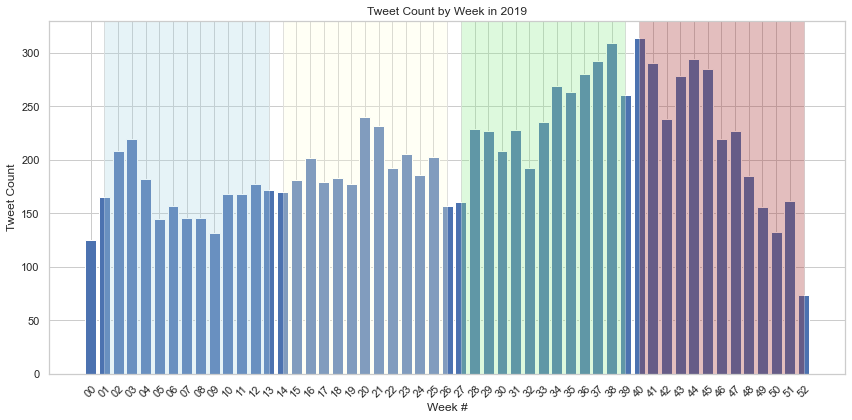

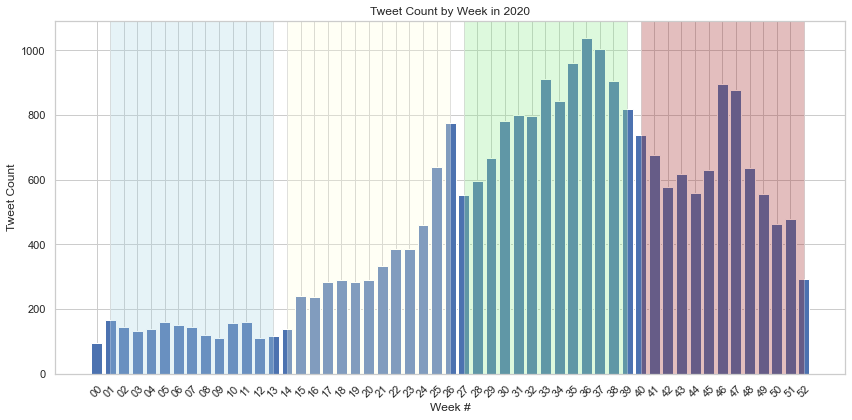

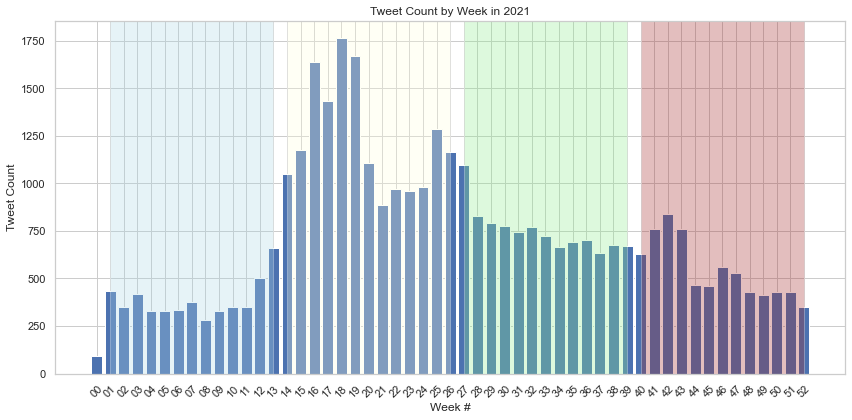

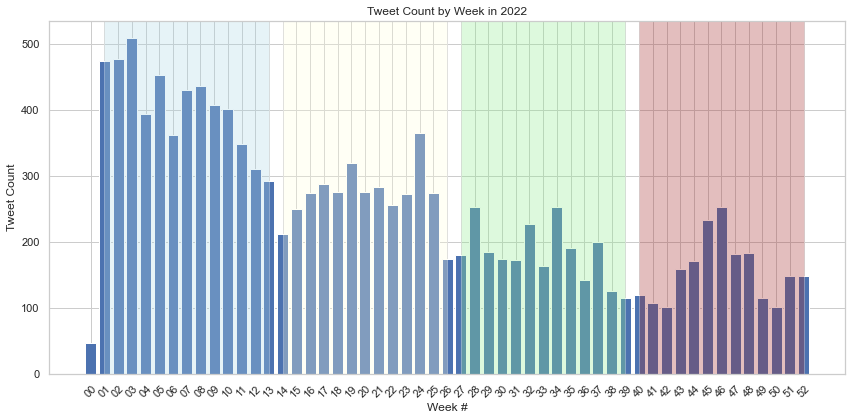

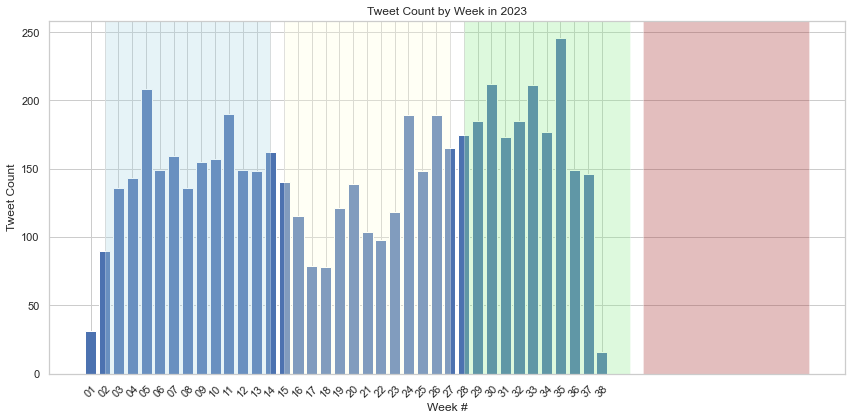

In [14]:
# TASK 3: let's now analyze tweets weekly over the course of the year
# Note: at the top of this notebook, we dropped all tweets that didn't have cities in their text. Most of them contained
# text like "Some fields are missing." Nevertheless, the following visualization of tweet volume is made using same df
df['timestamp'] = pd.to_datetime(df['timestamp'])

years = [2018, 2019, 2020, 2021, 2022, 2023]

for year in years:

    df_year = df[df['timestamp'].dt.year == year].copy()
    df_year['week'] = df_year['timestamp'].dt.strftime('%U')

    tweet_counts_by_week = df_year['week'].value_counts().sort_index()

    plt.figure(figsize = (12, 6))
    plt.bar(tweet_counts_by_week.index, tweet_counts_by_week.values)

    # visualizing seasons to better interpret data
    seasons = {"Winter": (1, 13), "Spring": (14, 26), "Summer": (27, 39), "Autumn": (40, 52)}
    season_colors = {"Winter": 'lightblue', "Spring": 'lightyellow', "Summer": 'lightgreen', "Autumn": 'brown'}
    for season, (start, end) in seasons.items():
        plt.axvspan(start, end, facecolor=season_colors[season], alpha=0.3, label=season)

    plt.xlabel('Week #')
    plt.ylabel('Tweet Count')
    plt.title(f'Tweet Count by Week in {year}')
    plt.xticks(rotation = 45)
    plt.tight_layout()
    
    filename = f'plot_{year}_week.pdf'

    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight', transparent=True)

    plt.show()

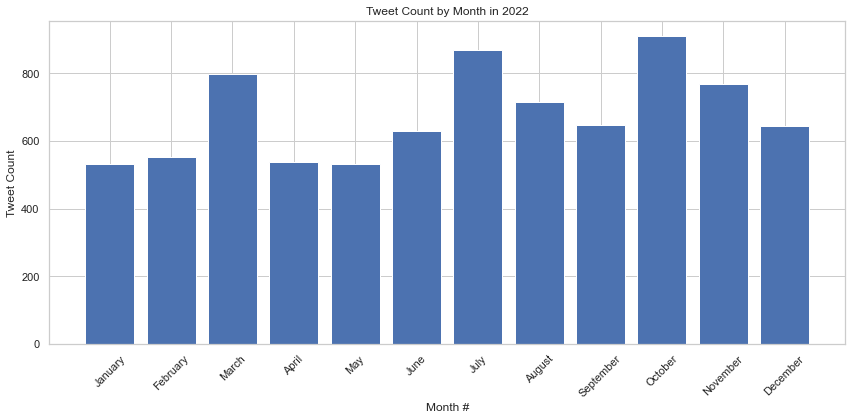

In [15]:
# The following visualization is not weekly but monthly
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

df['timestamp'] = pd.to_datetime(df['timestamp'])

df_2022 = df[df['timestamp'].dt.year == 2018].copy()
df_2022['month'] = df_2022['timestamp'].dt.strftime('%B')

tweet_counts_by_month = df_2022['month'].value_counts()
tweet_counts_by_month = tweet_counts_by_month.reindex(month_order)

plt.figure(figsize = (12, 6))
plt.bar(tweet_counts_by_month.index, tweet_counts_by_month.values)
plt.xlabel('Month #')
plt.ylabel('Tweet Count')
plt.title('Tweet Count by Month in 2022')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [16]:
# let's find days in years 2019-2023 with missing tweets in our dataset
df['date'] = pd.to_datetime(df['date'])

years = [2019, 2020, 2021, 2022]

for year in years:
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year}-12-31')
    date_range_year = pd.date_range(start_date, end_date)
    
    df_year = df[df['date'].dt.year == year].copy()
    existing_dates = df_year['date'].dt.date.unique()

    missing_dates = date_range_year[~date_range_year.isin(existing_dates)]
    missing_dates_list = missing_dates.strftime('%Y-%m-%d').tolist()
    print(f"Missing dates in {year}: {missing_dates_list}")
    
# separate code for 2023 since it's going to have a different date_range_year
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2023-09-18')
date_range_year = pd.date_range(start_date, end_date)
    
df_2023 = df[df['date'].dt.year == 2023].copy()
existing_dates = df_2023['date'].dt.date.unique()

missing_dates = date_range_year[~date_range_year.isin(existing_dates)]
missing_dates_list = missing_dates.strftime('%Y-%m-%d').tolist()
print("Missing dates in 2023:", missing_dates_list)

Missing dates in 2019: []
Missing dates in 2020: []
Missing dates in 2021: []
Missing dates in 2022: ['2022-08-15']
Missing dates in 2023: ['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-07']


In [17]:
# let's find weeks in year 2018 with missing tweets in our dataset
df_2018 = df[df['date'].dt.year == 2018].copy()
df_2018['week'] = df_2018['date'].dt.strftime('%U')
existing_weeks = df_2018['week'].unique().astype(int)

missing_weeks = [week for week in range(1, 53) if week not in existing_weeks.tolist()]
print("Missing weeks in 2018:", missing_weeks)

Missing weeks in 2018: []


In [18]:
df.to_csv('df_for_analysis.csv', index = False)